In [1]:
import os
import cv2
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util import montage
from skimage.morphology import label
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

In [2]:
import skimage

In [3]:
DATA_PATH = '/home/wentao/Development/data/ships_detection'
TRAIN_DIR = os.path.join(DATA_PATH, 'train')
TEST_DIR = os.path.join(DATA_PATH, 'test')
SAMPLE_CSV = os.path.join(DATA_PATH, 'sample_submission.csv')
MASKS_CSV = os.path.join(DATA_PATH, 'train_ship_segmentations.csv')

In [4]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [5]:
masks_df = pd.read_csv(MASKS_CSV)
masks_df.shape

(131030, 2)

In [6]:
masks_df['ImageId'].nunique()

104070

In [7]:
ships_df = masks_df[masks_df['EncodedPixels'].isnull() == False]

In [127]:
ships_df['ImageId'].unique()

array(['000155de5.jpg', '00021ddc3.jpg', '0002756f7.jpg', ...,
       'fff529a0e.jpg', 'fff67c31a.jpg', 'fff77c602.jpg'], dtype=object)

In [8]:
ships_id = ships_df['ImageId'].unique()

In [9]:
ships_id

array(['000155de5.jpg', '00021ddc3.jpg', '0002756f7.jpg', ...,
       'fff529a0e.jpg', 'fff67c31a.jpg', 'fff77c602.jpg'], dtype=object)

In [95]:
?? regionprops

Found bbox (465, 344, 501, 448)


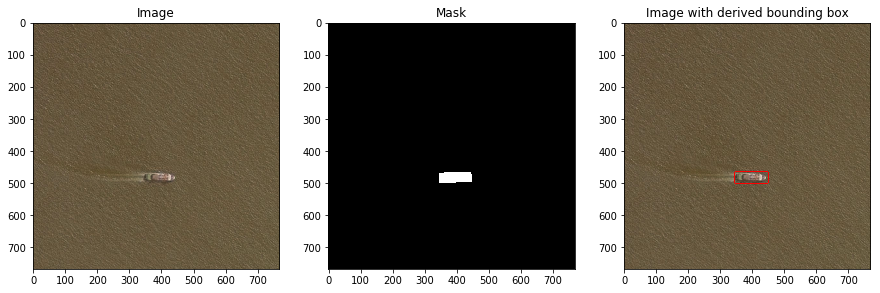

In [64]:
for i in range(1):
    image_id = ships_id[i]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    
    img_0 = cv2.imread(os.path.join(TRAIN_DIR, image_id))
    rle_0 = ships_df[ships_df['ImageId'] == image_id]['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    
    lbl_0 = label(mask_0)
    props = regionprops(lbl_0)
    
    img_1 = img_0.copy()
    
    for prop in props:
        print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)
    
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image with derived bounding box')
    
    ax1.imshow(img_0)
    ax2.imshow(mask_0[...,0], cmap='gray')
    ax3.imshow(img_1)
    plt.show()

In [65]:
mask_0.shape

(768, 768, 1)

In [66]:
mask_0.shape

(768, 768, 1)

In [67]:
np.max(mask_0)

1

In [55]:
mask_0[...,0].shape

(768, 768)

In [70]:
skimage.io.imsave(os.path.join(MASK_DIR, 'test.png'), mask_0[..., 0])

/home/wentao/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/wentao/Development/data/ships_detection/masks/test.png is a low contrast image
  warn('%s is a low contrast image' % fname)


In [71]:
masks = []
masks.append(mask_0)
masks.append(mask_0)

In [75]:
np.asarray(masks).shape

(2, 768, 768, 1)

In [82]:
mask_0[..., 0].shape

(768, 768)

In [83]:
img = PIL.Image.fromarray(mask_0[...,0])
output = io.BytesIO()
img.save(output, format='PNG')

In [84]:
output.getvalue()

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\x00\x00\x00\x03\x00\x10\x00\x00\x00\x00\xe6z\x83\x11\x00\x00\x05\x14IDATx\x9c\xed\xdd\xcb\r\xc20\x10@\xc1\x80\xd2\x7f\xcb\xd0\x00\xe2#El\xe27S\xc1^\xb2\xcf\x87\xc8\xde6\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x